In [1]:
import os
import numpy as np
import random
import tensorflow as tf

os.environ['PYTHONHASHSEED'] = '42'
os.environ["TF_DETERMINISTIC_OPS"] = "1"

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, Bidirectional

df = pd.read_csv('/content/city_day.csv')

print(f"NaN values in dataset before cleaning: {df.isna().sum().sum()}")

df = df.dropna()
print(f"NaN values after cleaning: {df.isna().sum().sum()}")
print(f"Shape after cleaning: {df.shape}")

features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']

X = df[features].values
y = df['AQI'].values

X = np.nan_to_num(X)
y = np.nan_to_num(y)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

X_train_cl = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_cl = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

NaN values in dataset before cleaning: 88488
NaN values after cleaning: 0
Shape after cleaning: (6236, 16)


In [3]:
# ---------------- CNN MODEL ---------------- #
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, X_train.shape[1])))
cnn_model.add(MaxPooling1D(pool_size=1))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1))

cnn_model.compile(optimizer='adam', loss='mse')

cnn_history = cnn_model.fit(
    X_train_cl, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=1
)
# ---------------- Evaluation ---------------- #
cnn_train_pred = cnn_model.predict(X_train_cl)
cnn_train_pred_inv = scaler_y.inverse_transform(cnn_train_pred)
y_train_actual = scaler_y.inverse_transform(y_train)

print(" CNN Training Evaluation:")
print("RMSE:", sqrt(mean_squared_error(y_train_actual, cnn_train_pred_inv)))
print("MAE :", mean_absolute_error(y_train_actual, cnn_train_pred_inv))
print("R²  :", r2_score(y_train_actual, cnn_train_pred_inv))

cnn_predictions = cnn_model.predict(X_test_cl)
cnn_predictions = scaler_y.inverse_transform(cnn_predictions)
y_test_actual = scaler_y.inverse_transform(y_test)

cnn_rmse = sqrt(mean_squared_error(y_test_actual, cnn_predictions))
cnn_mae = mean_absolute_error(y_test_actual, cnn_predictions)
cnn_r2 = r2_score(y_test_actual, cnn_predictions)

print("\nCNN Test Evaluation:")
print("RMSE:", cnn_rmse)
print("MAE :", cnn_mae)
print("R²  :", cnn_r2)


# ---------------- Sample Prediction ---------------- #
sample_input = pd.DataFrame([[26,50,1,19,18,23,1,3,42,2,6,1]], columns=features)

sample_scaled = scaler_X.transform(sample_input)
sample_seq = sample_scaled.reshape(1, 1, sample_scaled.shape[1])

sample_pred = cnn_model.predict(sample_seq)
sample_pred = scaler_y.inverse_transform(sample_pred)

def get_aqi_quality(aqi):
    if aqi <= 50:  return "Good"
    elif aqi <= 100: return "Satisfactory"
    elif aqi <= 200: return "Moderate"
    elif aqi <= 300: return "Poor"
    else: return "Very Poor"

print("\nCNN Sample AQI:", sample_pred[0][0])
print("AQI Quality:", get_aqi_quality(sample_pred[0][0]))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0136 - val_loss: 0.0015
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 10/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 11/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 12/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [4]:

# ---------------- LSTM MODEL ---------------- #
lstm_model = Sequential()
lstm_model.add(LSTM(100, return_sequences=False, input_shape=(1, X_train.shape[1])))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(50, activation='relu'))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mse')

lstm_history = lstm_model.fit(
    X_train_cl, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=1
)

# ---------------- TRAIN EVALUATION ---------------- #
lstm_train_pred = lstm_model.predict(X_train_cl)
lstm_train_pred_inv = scaler_y.inverse_transform(lstm_train_pred)
y_train_actual = scaler_y.inverse_transform(y_train)

print("\nLSTM Training Evaluation:")
print("RMSE:", sqrt(mean_squared_error(y_train_actual, lstm_train_pred_inv)))
print("MAE :", mean_absolute_error(y_train_actual, lstm_train_pred_inv))
print("R²  :", r2_score(y_train_actual, lstm_train_pred_inv))

# ---------------- TEST EVALUATION ---------------- #
lstm_predictions = lstm_model.predict(X_test_cl)
lstm_predictions = scaler_y.inverse_transform(lstm_predictions)
y_test_actual = scaler_y.inverse_transform(y_test)

lstm_rmse = sqrt(mean_squared_error(y_test_actual, lstm_predictions))
lstm_mae = mean_absolute_error(y_test_actual, lstm_predictions)
lstm_r2 = r2_score(y_test_actual, lstm_predictions)

print("\nLSTM Test Evaluation:")
print("RMSE:", lstm_rmse)
print("MAE :", lstm_mae)
print("R²  :", lstm_r2)

# ---------------- SAMPLE PREDICTION ---------------- #
sample_input = pd.DataFrame([[26,50,1,19,18,23,1,3,42,2,6,1]], columns=features)

sample_scaled = scaler_X.transform(sample_input)
sample_reshaped = sample_scaled.reshape(1,1,sample_scaled.shape[1])

lstm_pred = lstm_model.predict(sample_reshaped)
lstm_pred = scaler_y.inverse_transform(lstm_pred)

def get_aqi_quality(aqi):
    if aqi <= 50: return "Good"
    elif aqi <= 100: return "Satisfactory"
    elif aqi <= 200: return "Moderate"
    elif aqi <= 300: return "Poor"
    else: return "Very Poor"

print("\nLSTM Model Prediction:")
print("AQI:", lstm_pred[0][0])
print("AQI Quality:", get_aqi_quality(lstm_pred[0][0]))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0180 - val_loss: 0.0022
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 10/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 11/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 12/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [5]:

# ---------------- BiLSTM MODEL ---------------- #
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(100, return_sequences=False), input_shape=(1, X_train.shape[1])))
bilstm_model.add(Dropout(0.3))
bilstm_model.add(Dense(50, activation='relu'))
bilstm_model.add(Dense(1))

bilstm_model.compile(optimizer='adam', loss='mse')

bilstm_history = bilstm_model.fit(
    X_train_cl, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=1
)

# ---------------- TRAIN EVALUATION ---------------- #
bilstm_train_pred = bilstm_model.predict(X_train_cl)
bilstm_train_pred_inv = scaler_y.inverse_transform(bilstm_train_pred)
y_train_actual = scaler_y.inverse_transform(y_train)

print("\nBiLSTM Training Evaluation:")
print("RMSE:", sqrt(mean_squared_error(y_train_actual, bilstm_train_pred_inv)))
print("MAE :", mean_absolute_error(y_train_actual, bilstm_train_pred_inv))
print("R²  :", r2_score(y_train_actual, bilstm_train_pred_inv))

# ---------------- TEST EVALUATION ---------------- #
bilstm_predictions = bilstm_model.predict(X_test_cl)
bilstm_predictions = scaler_y.inverse_transform(bilstm_predictions)
y_test_actual = scaler_y.inverse_transform(y_test)

bilstm_rmse = sqrt(mean_squared_error(y_test_actual, bilstm_predictions))
bilstm_mae = mean_absolute_error(y_test_actual, bilstm_predictions)
bilstm_r2 = r2_score(y_test_actual, bilstm_predictions)

print("\nBiLSTM Test Evaluation:")
print("RMSE:", bilstm_rmse)
print("MAE :", bilstm_mae)
print("R²  :", bilstm_r2)

# ---------------- SAMPLE PREDICTION ---------------- #
sample_input = pd.DataFrame([[26,50,1,19,18,23,1,3,42,2,6,1]], columns=features)

sample_scaled = scaler_X.transform(sample_input)
sample_reshaped = sample_scaled.reshape(1,1,sample_scaled.shape[1])

bilstm_pred = bilstm_model.predict(sample_reshaped)
bilstm_pred = scaler_y.inverse_transform(bilstm_pred)

def get_aqi_quality(aqi):
    if aqi <= 50: return "Good"
    elif aqi <= 100: return "Satisfactory"
    elif aqi <= 200: return "Moderate"
    elif aqi <= 300: return "Poor"
    else: return "Very Poor"

print("\nBiLSTM Model Prediction:")
print("AQI:", bilstm_pred[0][0])
print("AQI Quality:", get_aqi_quality(bilstm_pred[0][0]))


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0165 - val_loss: 0.0021
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 10/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 11/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 12/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [6]:
# ---------------- CNN + LSTM MODEL ---------------- #
cnn_lstm_model = Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, X_train.shape[1])))
cnn_lstm_model.add(MaxPooling1D(pool_size=1))
cnn_lstm_model.add(LSTM(100, return_sequences=False))
cnn_lstm_model.add(Dropout(0.3))
cnn_lstm_model.add(Dense(50, activation='relu'))
cnn_lstm_model.add(Dense(1))

cnn_lstm_model.compile(optimizer='adam', loss='mse')

cnn_lstm_history = cnn_lstm_model.fit(
    X_train_cl, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=1
)

train_pred = cnn_lstm_model.predict(X_train_cl)
train_pred = scaler_y.inverse_transform(train_pred)
y_train_actual = scaler_y.inverse_transform(y_train)

train_rmse = sqrt(mean_squared_error(y_train_actual, train_pred))
train_mae = mean_absolute_error(y_train_actual, train_pred)
train_r2 = r2_score(y_train_actual, train_pred)

print("\nCNN + LSTM Training:")
print("RMSE:", train_rmse)
print("MAE :", train_mae)
print("R²  :", train_r2)

test_pred = cnn_lstm_model.predict(X_test_cl)
test_pred = scaler_y.inverse_transform(test_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

cnn_lstm_rmse = sqrt(mean_squared_error(y_test_actual, test_pred))
cnn_lstm_mae = mean_absolute_error(y_test_actual, test_pred)
cnn_lstm_r2 = r2_score(y_test_actual, test_pred)

print("\nCNN + LSTM Test Results:")
print("RMSE:", cnn_lstm_rmse)
print("MAE :", cnn_lstm_mae)
print("R²  :", cnn_lstm_r2)

sample_input = pd.DataFrame([[26,50,1,19,18,23,1,3,42,2,6,1]], columns=features)

sample_scaled = scaler_X.transform(sample_input)
sample_reshaped = sample_scaled.reshape(1,1,sample_scaled.shape[1])

pred = cnn_lstm_model.predict(sample_reshaped)
pred = scaler_y.inverse_transform(pred)

def get_aqi_quality(aqi):
    if aqi <= 50: return "Good"
    elif aqi <= 100: return "Satisfactory"
    elif aqi <= 200: return "Moderate"
    elif aqi <= 300: return "Poor"
    else: return "Very Poor"

print("\nPrediction AQI:", pred[0][0])
print("Quality:", get_aqi_quality(pred[0][0]))


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0165 - val_loss: 0.0017
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - val_loss: 9.9540e-04
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - val_loss: 9.9102e-04
Epoch 10/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 11/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0014 - val_loss: 9.6211e-04
Epoch 12/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/ste

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [7]:
# ---------------- CNN + BiLSTM HYBRID MODEL ---------------- #
hybrid_model = Sequential()
hybrid_model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(1, X_train.shape[1])))
hybrid_model.add(MaxPooling1D(pool_size=1))
hybrid_model.add(Bidirectional(LSTM(100, return_sequences=False)))
hybrid_model.add(Dropout(0.3))
hybrid_model.add(Dense(50, activation='relu'))
hybrid_model.add(Dense(1))

hybrid_model.compile(optimizer='adam', loss='mse')

hybrid_history = hybrid_model.fit(
    X_train_cl, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    shuffle=False,
    verbose=1
)

# ---------------- TRAIN EVALUATION ---------------- #
train_pred = hybrid_model.predict(X_train_cl)
train_pred_inv = scaler_y.inverse_transform(train_pred)
y_train_actual = scaler_y.inverse_transform(y_train)

print("\nCNN + BiLSTM Training Evaluation:")
print("RMSE:", sqrt(mean_squared_error(y_train_actual, train_pred_inv)))
print("MAE :", mean_absolute_error(y_train_actual, train_pred_inv))
print("R²  :", r2_score(y_train_actual, train_pred_inv))

# ---------------- TEST EVALUATION ---------------- #
test_pred = hybrid_model.predict(X_test_cl)
test_pred = scaler_y.inverse_transform(test_pred)
y_test_actual = scaler_y.inverse_transform(y_test)

cnn_bilstm_rmse = sqrt(mean_squared_error(y_test_actual, test_pred))
cnn_bilstm_mae = mean_absolute_error(y_test_actual, test_pred)
cnn_bilstm_r2 = r2_score(y_test_actual, test_pred)

print("\nCNN + BiLSTM Test Evaluation:")
print("RMSE:", cnn_bilstm_rmse)
print("MAE :", cnn_bilstm_mae)
print("R²  :", cnn_bilstm_r2)

# ---------------- SAMPLE PREDICTION ---------------- #
sample_input = pd.DataFrame([[26,50,1,19,18,23,1,3,42,2,6,1]], columns=features)
sample_scaled = scaler_X.transform(sample_input)
sample_reshaped = sample_scaled.reshape(1,1,sample_scaled.shape[1])

pred = hybrid_model.predict(sample_reshaped)
pred = scaler_y.inverse_transform(pred)

def get_aqi_quality(aqi):
    if aqi <= 50: return "Good"
    elif aqi <= 100: return "Satisfactory"
    elif aqi <= 200: return "Moderate"
    elif aqi <= 300: return "Poor"
    else: return "Very Poor"

print("\nPrediction AQI:", pred[0][0])
print("Quality:", get_aqi_quality(pred[0][0]))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0133 - val_loss: 0.0016
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 10/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 11/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 12/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/st

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


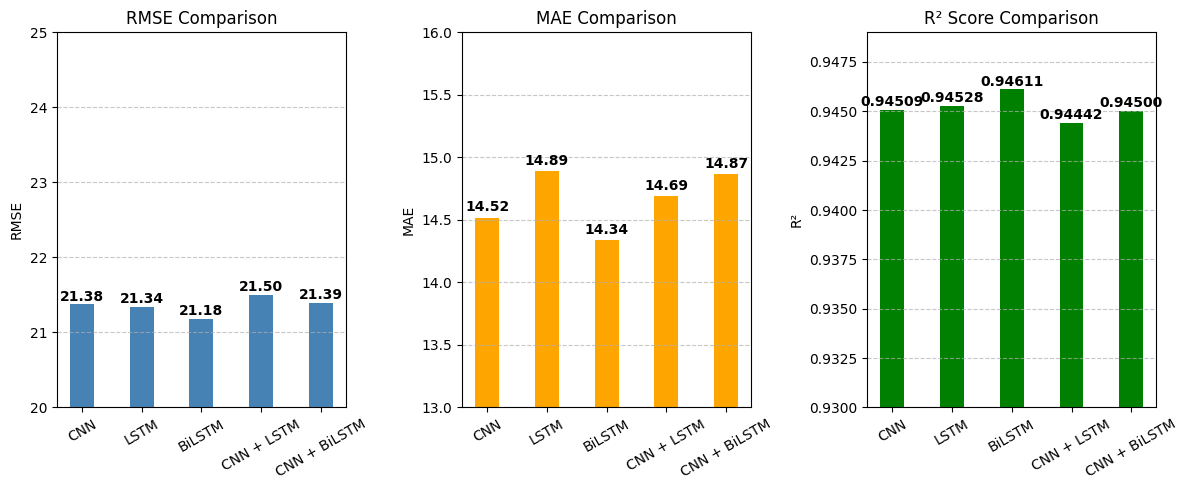

In [8]:
models = ['CNN', 'LSTM', 'BiLSTM', 'CNN + LSTM', 'CNN + BiLSTM']

rmse_values = [cnn_rmse, lstm_rmse, bilstm_rmse, cnn_lstm_rmse, cnn_bilstm_rmse]
mae_values = [cnn_mae, lstm_mae, bilstm_mae, cnn_lstm_mae, cnn_bilstm_mae]
r2_values  = [cnn_r2, lstm_r2, bilstm_r2, cnn_lstm_r2, cnn_bilstm_r2]

bar_width = 0.4
x = np.arange(len(models))

plt.figure(figsize=(12, 5))

# R² Score
plt.subplot(1, 3, 3)
plt.bar(x, r2_values, color=['green'], width=bar_width)
plt.xticks(x, models, rotation=30)
plt.title('R² Score Comparison')
plt.ylabel('R²')
plt.ylim(0.93, 0.949)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(r2_values):
    plt.text(i, v + 0.0002, f'{v:.5f}', ha='center', fontweight='bold')

# RMSE Comparison
plt.subplot(1, 3, 1)
plt.bar(x, rmse_values, color=['steelblue'], width=bar_width)
plt.xticks(x, models, rotation=30)
plt.title('RMSE Comparison')
plt.ylabel('RMSE')
plt.ylim(20, 25)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(rmse_values):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')


# MAE Comparison
plt.subplot(1, 3, 2)
plt.bar(x, mae_values, color=['orange'], width=bar_width)
plt.xticks(x, models, rotation=30)
plt.title('MAE Comparison')
plt.ylabel('MAE')
plt.ylim(13, 16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(mae_values):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()
